## 1. Import Libraries

In [23]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
import collections
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os 

#global parameters
max_length = 384
doc_stride = 128
os.environ["WANDB_DISABLED"] = "true"

#quick checks
print(f"Using {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using Tesla V100-SXM2-32GB


## 2. Load the Spoken-SQuAD Dataset

In [9]:
spoken_squad_dataset = load_dataset(
    "json",
    data_files={
        "train": "https://raw.githubusercontent.com/chiahsuan156/Spoken-SQuAD/master/spoken_train-v1.1.json",
        "test": "https://raw.githubusercontent.com/chiahsuan156/Spoken-SQuAD/master/spoken_test-v1.1.json",
        "test_wer44": "https://raw.githubusercontent.com/chiahsuan156/Spoken-SQuAD/master/spoken_test-v1.1_WER44.json",
        "test_wer54": "https://raw.githubusercontent.com/chiahsuan156/Spoken-SQuAD/master/spoken_test-v1.1_WER54.json"
    },
    field="data"
)

## 3. Load Tokenizer and Model

In [10]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Preprocessing the Data

In [30]:
def preprocess_function(examples):
    questions = []
    contexts = []
    answers = []
    
    # handle the nested structure of spoken-squad
    for paragraphs in examples['paragraphs']:
        for paragraph in paragraphs:
            context = paragraph['context']
            for qa in paragraph['qas']:
                questions.append(qa['question'])
                contexts.append(context)
                answers.append(qa['answers'][0])
    
    tokenized_examples = tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    sample_mapping = tokenized_examples["overflow_to_sample_mapping"]
    offset_mapping = tokenized_examples["offset_mapping"]
    
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    
    for i, offsets in enumerate(offset_mapping):
        sample_index = sample_mapping[i]
        answer = answers[sample_index]
        start_char = answer["answer_start"]
        end_char = start_char + len(answer["text"])
        
        sequence_ids = tokenized_examples.sequence_ids(i)
        
        # find context start/end
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1
        
        # check if answer is in this window
        if offsets[context_start][0] > start_char or offsets[context_end][1] < end_char:
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)
        else:
            # find token positions
            token_start = context_start
            while token_start <= context_end and offsets[token_start][0] < start_char:
                token_start += 1
            tokenized_examples["start_positions"].append(token_start)
            
            token_end = context_end
            while token_end >= context_start and offsets[token_end][1] > end_char:
                token_end -= 1
            tokenized_examples["end_positions"].append(token_end)
    
    return tokenized_examples

In [ ]:
# process data
tokenized_datasets = spoken_squad_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=spoken_squad_dataset["train"].column_names
)

Map:   0%|          | 0/442 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

## 5. Training the Model

In [ ]:
# trainer handles lr decay
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# train model and save 
trainer.train()
trainer.save_model("./rkc_qa_model")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/local_scratch/slurm.6607924/ipykernel_2104807/2987031444.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/rchamar/.conda/envs/PytorchWorkshop/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.279000
1000,0.383200
1500,0.442700


/home/rchamar/.conda/envs/PytorchWorkshop/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rchamar/.conda/envs/PytorchWorkshop/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rchamar/.conda/envs/PytorchWorkshop/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


## 6. Postprocessing (Evaluation)

In [35]:
# helper functions to calculate exact match and f1 score
def calculate_em(predictions, dataset):
    correct = 0
    total = 0
    for example in dataset: # example is an article
        for paragraph in example["paragraphs"]: # loop through paragraphs
            for qa in paragraph["qas"]: # loop through qas
                qid = qa["id"]
                true_ans = qa["answers"][0]["text"].strip().lower()
                pred_ans = predictions.get(qid, "").strip().lower()
                if pred_ans == true_ans:
                    correct += 1
                total += 1
    if total == 0: return 0
    return (correct / total) * 100

def calculate_f1(predictions, dataset):
    total_f1 = 0
    total_qas = 0 # use this as the denominator
    for example in dataset: # example is an article
        for paragraph in example["paragraphs"]: # loop through paragraphs
            for qa in paragraph["qas"]: # loop through qas
                total_qas += 1
                qid = qa["id"]
                true_ans = qa["answers"][0]["text"].strip().lower()
                pred_ans = predictions.get(qid, "").strip().lower()
                
                # tokenize by splitting on whitespace
                true_tokens = true_ans.split()
                pred_tokens = pred_ans.split()
                
                if len(pred_tokens) == 0 or len(true_tokens) == 0:
                    if len(pred_tokens) == len(true_tokens):
                        total_f1 += 1.0
                    continue
                
                # count common tokens
                common = sum((min(true_tokens.count(t), pred_tokens.count(t)) for t in set(true_tokens)))
                
                if common == 0:
                    continue
                    
                precision = common / len(pred_tokens)
                recall = common / len(true_tokens)
                f1 = 2 * (precision * recall) / (precision + recall)
                total_f1 += f1
    
    if total_qas == 0: return 0
    return (total_f1 / total_qas) * 100

In [ ]:
# evaluate on test set 
# for each question: 
#   - get top 20 start/end logits
#   - try combinations and filter out invalid ones 
#   - extract text for valid combinations 
#   - select answer with highest logit score 
#   - compare to score for no answer and return empty string if no answer is better
def evaluate_on_test_set(test_name):
    print(f"evaluating {test_name}...")
    
    # get predictions
    preds = trainer.predict(tokenized_datasets[test_name])
    
    features = tokenized_datasets[test_name]
    examples = spoken_squad_dataset[test_name]
    
    # create a map from sample_index -> [feature_indices]
    feat_to_sample = collections.defaultdict(list)
    for i in range(len(features)):
        feat_to_sample[features[i]["overflow_to_sample_mapping"]].append(i)
    
    # create a flat list of all qas (samples) from the original dataset
    # this is the "ground truth" that sample_index maps to
    all_qas = []
    for example in examples: # example is an article
        for paragraph in example["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                all_qas.append({"qa": qa, "context": context})
    
    start_logits = preds.predictions[0]
    end_logits = preds.predictions[1]
    predictions = collections.OrderedDict()
    
    # now, loop over the flat list of qas, using its index as the sample_index
    for sample_index, sample in enumerate(tqdm(all_qas)):
        feat_idxs = feat_to_sample.get(sample_index, []) # get features for this qa
        min_null = None
        answers = []
        context = sample["context"]
        
        for f_idx in feat_idxs:
            s_logits = start_logits[f_idx]
            e_logits = end_logits[f_idx]
            offsets = features[f_idx]["offset_mapping"]
            
            # null answer
            null_score = s_logits[0] + e_logits[0]
            if min_null is None or min_null > null_score:
                min_null = null_score
            
            # get top candidates
            starts = np.argsort(s_logits)[-1:-21:-1].tolist()
            ends = np.argsort(e_logits)[-1:-21:-1].tolist()
            
            for si in starts:
                for ei in ends:
                    if (si >= len(offsets) or ei >= len(offsets) or 
                        offsets[si] is None or offsets[ei] is None or ei < si):
                        continue
                    
                    text = context[offsets[si][0]:offsets[ei][1]]
                    answers.append({
                        "score": s_logits[si] + e_logits[ei],
                        "text": text
                    })
        
        best = sorted(answers, key=lambda x: x["score"], reverse=True)[0] if answers else {"text": "", "score": 0}
        qid = sample["qa"]["id"] # get qid from the sample
        predictions[qid] = best["text"] if best["score"] > min_null else ""
    
    em = calculate_em(predictions, examples)
    f1 = calculate_f1(predictions, examples)
    print(f"{test_name}: EM={em:.2f}%, F1={f1:.2f}%")
    
    # return f1 as well, because the final plotting cell needs it
    return em, f1, predictions

In [ ]:
# run on all test sets
results = {}
for test_set in ["test", "test_wer44", "test_wer54"]:
    em, f1, preds = evaluate_on_test_set(test_set) # capture em, f1, and preds
    results[test_set] = {"em": em, "f1": f1, "predictions": preds} 

print("\n" + "="*40)
for name, data in results.items():
    wer = "22.73" if name == "test" else name.split("wer")[1]

    # print both em and f1
    print(f"{name} (wer {wer}): EM={data['em']:.2f}%, F1={data['f1']:.2f}%")

evaluating test...


  0%|          | 0/5351 [00:00<?, ?it/s]

test: EM=46.81%, F1=65.83%
evaluating test_wer44...


  0%|          | 0/5351 [00:00<?, ?it/s]

test_wer44: EM=27.02%, F1=45.74%
evaluating test_wer54...


  0%|          | 0/5351 [00:00<?, ?it/s]

test_wer54: EM=18.97%, F1=34.13%

test (wer 22.73): EM=46.81%, F1=65.83%
test_wer44 (wer 44): EM=27.02%, F1=45.74%
test_wer54 (wer 54): EM=18.97%, F1=34.13%


## 7. Plot

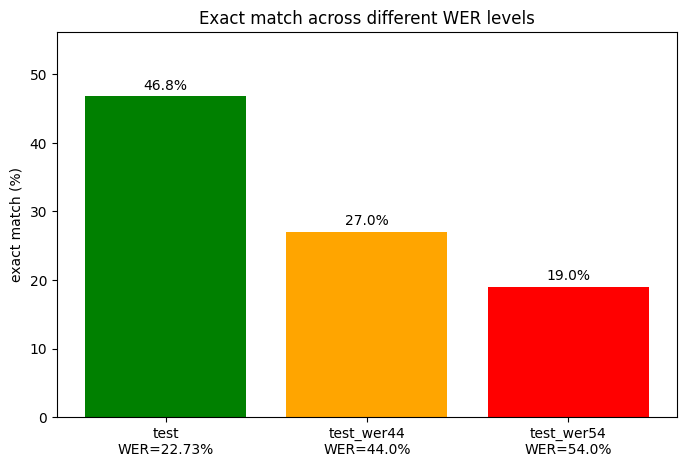

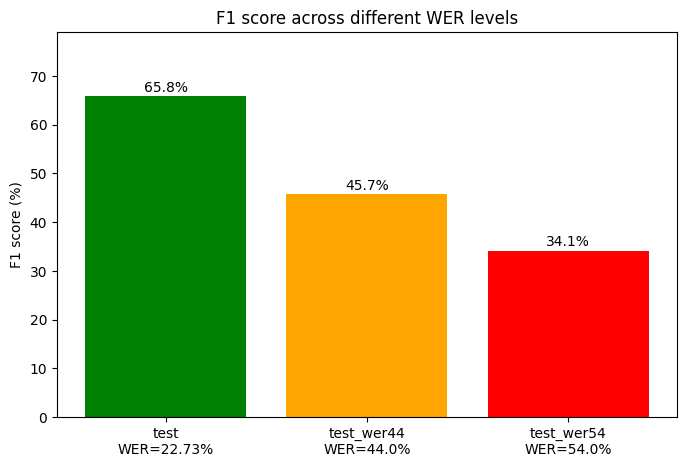

In [40]:
# plot results
names = []
em_scores = []
f1_scores = []
wers = []

for test_set, data in results.items():
    wer = 22.73 if test_set == "test" else float(test_set.split("wer")[1])
    names.append(f"{test_set}\nWER={wer}%")
    em_scores.append(data['em'])
    f1_scores.append(data['f1'])
    wers.append(wer)

# em bar chart
plt.figure(figsize=(8, 5))
plt.bar(names, em_scores, color=['green', 'orange', 'red'])
plt.ylabel('exact match (%)')
plt.title('Exact match across different WER levels')
plt.ylim(0, max(em_scores) * 1.2)
for i, v in enumerate(em_scores):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()

# f1 bar chart
plt.figure(figsize=(8, 5))
plt.bar(names, f1_scores, color=['green', 'orange', 'red'])
plt.ylabel('F1 score (%)')
plt.title('F1 score across different WER levels')
plt.ylim(0, max(f1_scores) * 1.2)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()